# The Social Network of Harry Potter
This notebook explains how the social network of Harry Potter is analysed through the 7 Harry Potter Books


## Setup
The functions referenced can be found in `HP_Network_funcs.py`

In [ ]:
# import own functions from HP_network_funcs.py
try:
    from HP_Network_funcs import *
except ModuleNotFoundError:
    !pip install -r requirements.txt
    from HP_Network_funcs import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## What information do we need?
In order to read through the book in a thoughtfull way, we need to clean the books and split them into chapters.
- 'Cleaning' involves removing html tags, spacings, side numbers and the author name from the book. 
- Splitting into chapters allows us to treat each chapter as a seperate document as the time and location often changes from chapter to chapter. Furthermore it gives us a timeline of the books
- Most characters have a list of nicknames, eg. 'Harry' and 'Potter' or 'Voldemort' and 'He-Who-Must-Not-Be-Named'. We wish to describe the interactions between characters, thus we need to be able to handle nicknames. This is done by (more or less manually) creating a dictionary of all nicknames the characters might have, read through the book and change all occurence of a name/nickname to the first name of that character.

In the cell below we load the chapter information dataframe and a library of characters and their respective Hogwarts Houses


In [ ]:
chapter_info = pd.read_pickle('data/chapter_dataframe.pkl')
#Add book number to chapters
idx = chapter_info.index[chapter_info["Local Chapter"] == 1]
for i in range(7):
    chapter_info.loc[idx[i]:(idx[i+1] if i+1 < len(idx) else None), "Book"] = int(i+1)
with open('data/characters_by_house.pkl', 'rb') as file:
    characters_by_communities = pkl.load(file)



With this information we can begin to clean the books!

We have created a seperate function `clean_books` to remove html-tags. 
We split the book every time we find a chapter name written in upper case letters. 
However due to ambiguities between the book and our scraped chapter info we use a similarity check to make sure we find the right spot to split.

Furthermore, we remove page numbering and J.K Rowling tags. The result is stored as a list of 7 (1 for each book) lists of chapters as a pickle file format and the code can be found in the function `books_in_chapters`

In [ ]:
books_in_chapters = books_in_chapters(chapter_info)

TypeError: 'list' object is not callable

## Actor Extraction
We use the character names that we scraped from the web as search words to see if we can find them in each chapter, where they appear.

Because the characters can be called by different names and nicknames we "normalize" the names in the book text to begin with.
We make it so all names and nicknames are replaced with the corresponding first name of the character in lower case e.g. _'voldemort'_ is sometimes called _'voldemort'_ or _'he-who-must-not-be-names'_ or _'tom riddle'_. We map them all to _'voldemort'_ 

The Hogwarts Houses of characters dictionary scraped from HP-lex.org is 'reversed' from House to list of characters to Charater to House in order to map the characters to their houses. 

Some rather unknown or unimportant characters are making this hard. For instance, Albus Potter is the son of Harry Potter but he cannot be mapped to neither Albus nor Harry for obvious reasons. He is simply removed from the network.

This is handled in the function `get_names`.

The file `books_in_chapters_names` are the books split into chapters and nicknames substituted with first names

In [ ]:
names, characters_by_communities_reverse = get_names(characters_by_communities)

regexPattern = "|".join(names.keys())
books_in_chapters_names = [[re.sub(regexPattern, lambda name: names[name.group()], chapter ) for chapter in book] for book in books_in_chapters]



## Finding interactions
To automatically find interactions between characters in a book seems simple at first but has perhaps been the most cumbersome and discussed subject in the progress of making this notebook...

We have defined an interaction from character A to character B by a sentence spoken by A to B.  <br>
Every chapter of the books is divied into paragraphs in which (with a high certainty) only 1 charater speaks. By finding this character we have the 'source' of the interaction. <br>
This is unfortunately not a trivial task. In many paragraphs the subject is 'he' or 'she' refering to some formerly mentioned character or the paragraph is only a 'spoken sentence' and the 'speaker' has to be inferred from the context. <br>
To tackle this problem we made the following heuristic: _if a paragraph includes speech the first character to mentioned in the context (outside of the speech) is the soruce of the interaction_ <br>
The heuristic is in no way bulletproof but it works most of the way since in the majority of paragraphs with speech, the speech is followed by 'said _A_' or 'asked _A_' etc.

Detecting the target is even more troublesome as the target more often than not is not mentioned in the paragraph. <br>
Mostly the target is a person who has just spoken or is about to speak, thus the made the following heuristic for detecting the target: _the target of an interaction is the source of 1 or more of the previous 2 or preceeding 2 interactions_

The result if a dictionary of dictonaries `interactions` in which `interactions[Source][Target]` gives all the interactions between Source and Target



In [ ]:
interactions, interactions_list = get_interactions(names, books_in_chapters_names)


198it [00:00, 435.64it/s]


## Creating the network
With the `interactions` dictionary the social network is easy to create: if A interacts with B we make a directed edge from A to B <br>
But we can make things more interesting if we include the sentiment of the interaction. Using VADER (Valence Aware Dictionary for Sentiment Reasoning) we can get an estimate of the polarity (negative or positive) of the interaction. VADER also takes the intensity of the interaction into account. <br>

We will use the Mean Vader Sentiment Compound score for the weights. This is just the mean of Vader-compound for all interactions between A and B.

The result is a directed network with signed and weighted edges.


In [ ]:
G = create_network(interactions, names, characters_by_communities_reverse) 


843

## Network analysis
First we will do some basic network analysis ...

- **Modularity**: We will compare the modularity of the Hogwarts House split by using a configuration model.
  - The configuration model has the same out- and in-degree distrubution as the original network, but the nodes are connected randomly
  - The formula for Modularity: .......
  - By creating 1000 configuration models and compare the modularity distrubution with the modularity of the true Hogwarts House split allows us to see whether the split is different than a random split
  - Modularity is difficult with signed weights - Thus we normalise the weights to be between 0 and 1

- **Communities**: We will compare the Hogwarts House community split with an 'optimal' split found using the Louvain community detection algorithm.
    - By checking how the houses distribute over the better partition we can get an intuition in how well the houses are defined.
    - The network has to be undirected to do this.

- **Degree distrubution**: We wish to investigate how the network behaves compared to a random network ....





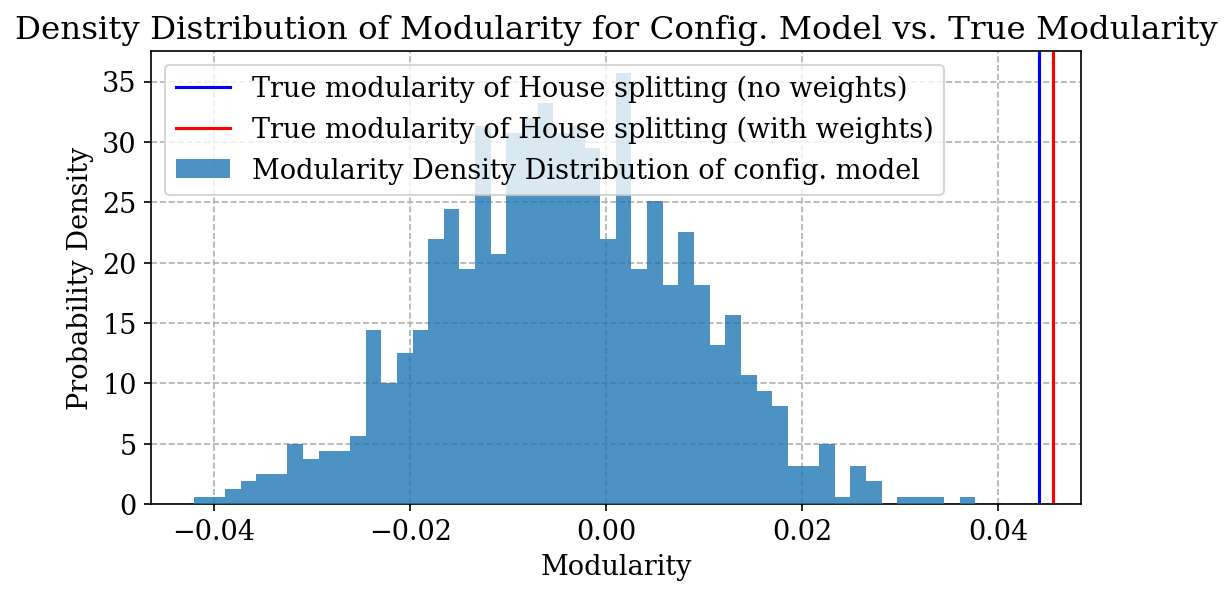

In [ ]:
network_analysis(G, characters_by_communities_reverse, names, "density", save_data = True)

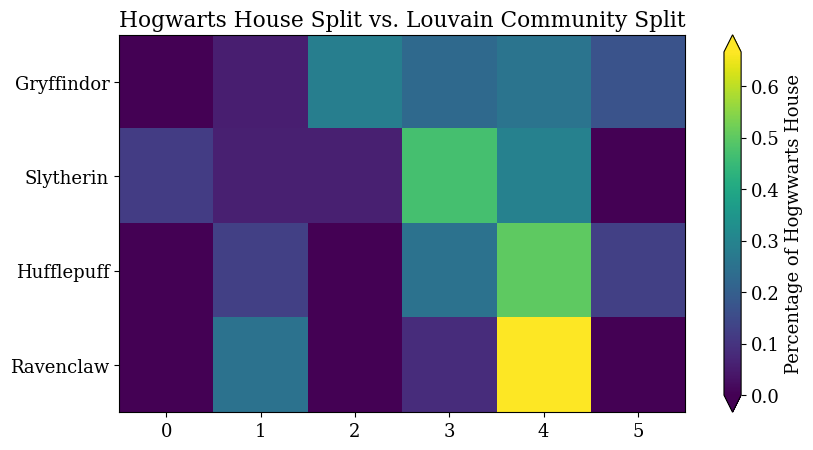

The modularity of the Louvain Community Split was: 0.178454075140379


In [ ]:
network_analysis(G,characters_by_communities_reverse, names, "louvain")

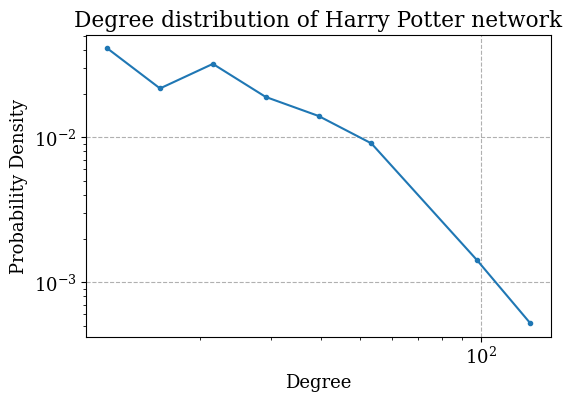

In [ ]:
network_analysis(G, characters_by_communities_reverse, names, "degree")

## Network Visualisation
We will use the python package pyvis to visualise the network. <br>
Green edges indicate an overall positive interaction and red edges a negative interaction. <br>
The nodes are colored according to houses:
- Gryffindor: red
- Slytherin: darkgreen
- Hufflepuff: orange
- Ravenclaw: navy blue

If characters interact less than 15 times througout the books we will remove the link between them. <br>
Singleton nodes are removed afterwards.

In [ ]:
from pyvis.network import Network
net = Network(notebook = True, height="560px", width="100%", directed = True)

g = G.copy()
chosen = {'Harry': 'Harry',
          'Ron': 'Ron',
          'Hermione': 'Hermione',
          'Severus': 'Snape',
          'Rubeus': 'Hagrid',
          'Albus': 'Dumbledore',
          'Voldemort': 'Voldemort',
          'Draco': 'Draco Malfoy',
          'Sirius':'Sirius',
          'Fred': 'Fred',
          'George': 'George',
          'Cedric': 'Cedric',
          'Cho': 'Cho',
          'Luna': 'Luna',
          'Neville': 'Neville',
          'Nymphadora': 'Tonks',
          'Minerva': 'McGonagall',
          'Remus': 'Remus Lupin',
          'Ginny': 'Ginny',
          'Bellatrix': 'Bellatrix',
          'Lucius': 'Lucius Malfoy'}   
unchosen = [node for node in g.nodes() if node not in chosen.keys()]
g.remove_nodes_from(unchosen)


for node, data in g.nodes(data = True):

    net.add_node(node, label = f'{chosen[node]}', 
                       level = np.exp(G.out_degree(node)),
                       color = data['group'],
                       title = chosen[node] )


for src, trg, data in g.edges(data = True):
    if abs(round(data['weight'],3)) != 0:
        net.add_edge(src,trg, color = 'red' if data['weight'] < 0 else 'green',
                            alpha = .2,
                            weight = data['weight'] * 100,
                            title = f'{chosen[src]} to {chosen[trg]}  ({round(data["weight"],3)})' )


net.barnes_hut(gravity = -8000,
               central_gravity=0.0,
               spring_length=1000,
               spring_strength=0.00,
               damping=0.29,
               )
net.set_edge_smooth('discrete')
net.show("example1.html")


net.write_html("example1.html", notebook=True) 

# Enough with the network! How do the characters interact ??
We can investigate how each character behaves based upon the word they use to interact with others. <br>
First we need to create a data frame of all the interactions in the books.
We will do this using the interaction list made for building the network. <br>
In addition, we will ad Sentiment and Happiness scores for each interaction

In [ ]:
df = interactions_df(interactions_list, characters_by_communities_reverse, names, chapter_info)

df

,Chapter,Source,Target,Interaction,Tokens,Source_house,Target_house,Sentiment,Happiness,Happiness_norm,Book
0,0,Albus,Minerva,"You can’t blame them, We’ve had precious littl...","[you, cant, blame, weve, precious, little, cel...",Gryffindor,Gryffindor,0.029410,5.417500,0.552187,1.0
1,0,Minerva,Albus,"I know that,","[i, know]",Gryffindor,Gryffindor,0.000000,6.010000,0.626250,1.0
2,0,Albus,Minerva,"A fine thing it would be if, on the very day ...","[a, fine, thing, would, day, voldemort, seems,...",Gryffindor,Gryffindor,0.025489,5.320000,0.540000,1.0
3,0,Minerva,Albus,"My dear Professor, surely a sensible person li...","[my, dear, professor, surely, sensible, person...",Gryffindor,Gryffindor,0.022608,5.558000,0.569750,1.0
4,0,Minerva,Albus,"I know you haven’t, But you’re different. Eve...","[i, know, havent, but, youre, different, every...",Gryffindor,Gryffindor,0.013903,5.246154,0.530769,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15291,197,Ron,Hermione,Are you sure?,"[are, sure]",Gryffindor,Gryffindor,0.000000,5.740000,0.592500,7.0
15292,197,Hermione,Harry,"I think Harry’s right,","[i, think, harrys, right]",Gryffindor,Gryffindor,0.000000,6.220000,0.652500,7.0
15293,197,Hermione,Ron,"I think Harry’s right,","[i, think, harrys, right]",Gryffindor,Gryffindor,0.000000,6.220000,0.652500,7.0
15294,197,Harry,Ron,"That wand’s more trouble than it’s worth, And ...","[that, wands, trouble, worth, and, quite, hone...",Gryffindor,Gryffindor,0.018170,5.158000,0.519750,7.0


## Wordclouds
Using the Term Frequency and Inverse Term Frequency we can build word clouds of words used frequently and specially for different characters. <br>
This gives us a qualitative insight in the character and we can compare different characters easily.

100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


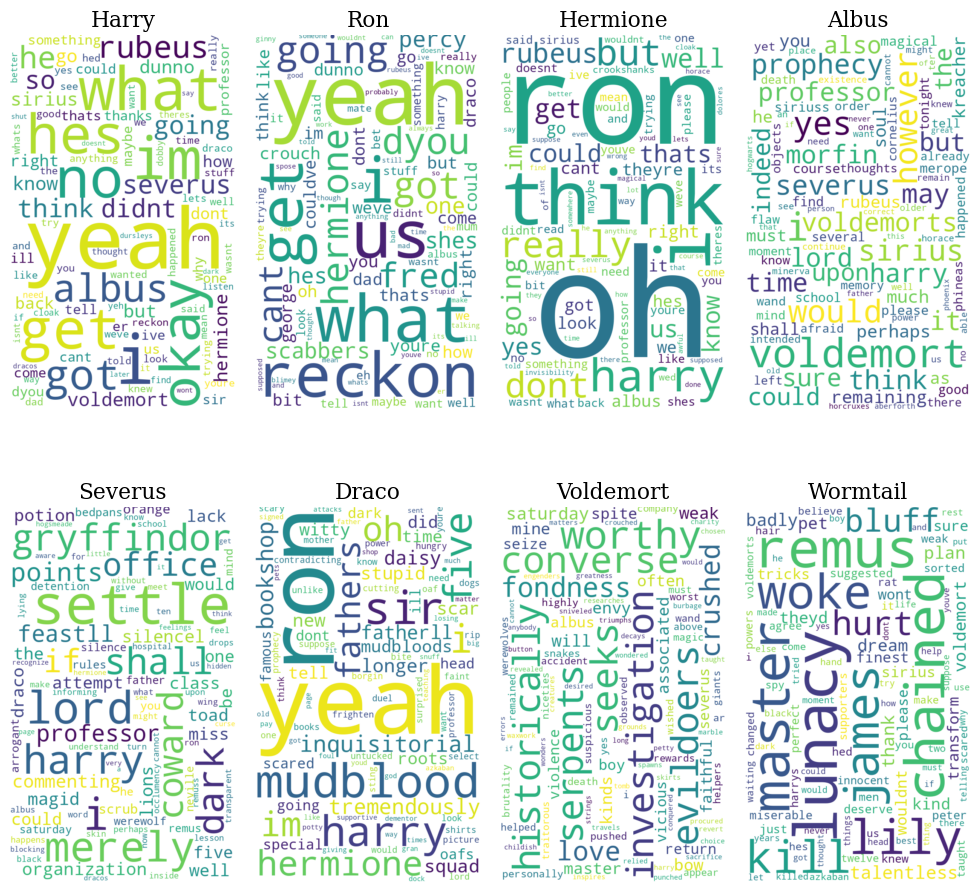

In [ ]:

Selected_characters = ['Harry', 'Ron', 'Hermione', 'Albus', 'Severus', 'Draco', 'Voldemort', 'Wormtail'] # Choose 8 characters

WordCloudsCharacters(df, Selected_characters)


The results are not at all surprising! <br>
Hermione is the cautios one of the trio consisting of Harry, Ron and herself. Her wordcloud includes 'oh', 'dont', 'really' and 'think' all words of a carefull mind. <br>
Interestingly, it seems like Ron and Hermione mention eachother names quite often - maybe they slander eachoter to Harry? <br>
Dumbledore is obviously obsessed with Voldemorts and Prophecies ... <br>
Malfoy is all about his father, scars and mudblood ... <br>
Perhaps, Wormtail suffers from a bad conscience? He talks a lot about all the ones he betrayed...


## Conditional interactions
One things is how characters talk. Another is how they talk to each other.

We can use an emotion lexicon which maps word to 8 different emotions:
- Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surprise and Trust

With this we can tie an emotion from one character to another. The emotion scores vary alot and if 2 persons interacts frequently emotions get mixed.
To 'normalize' this we use a softmax distribution to map emotion score to a probability distribution

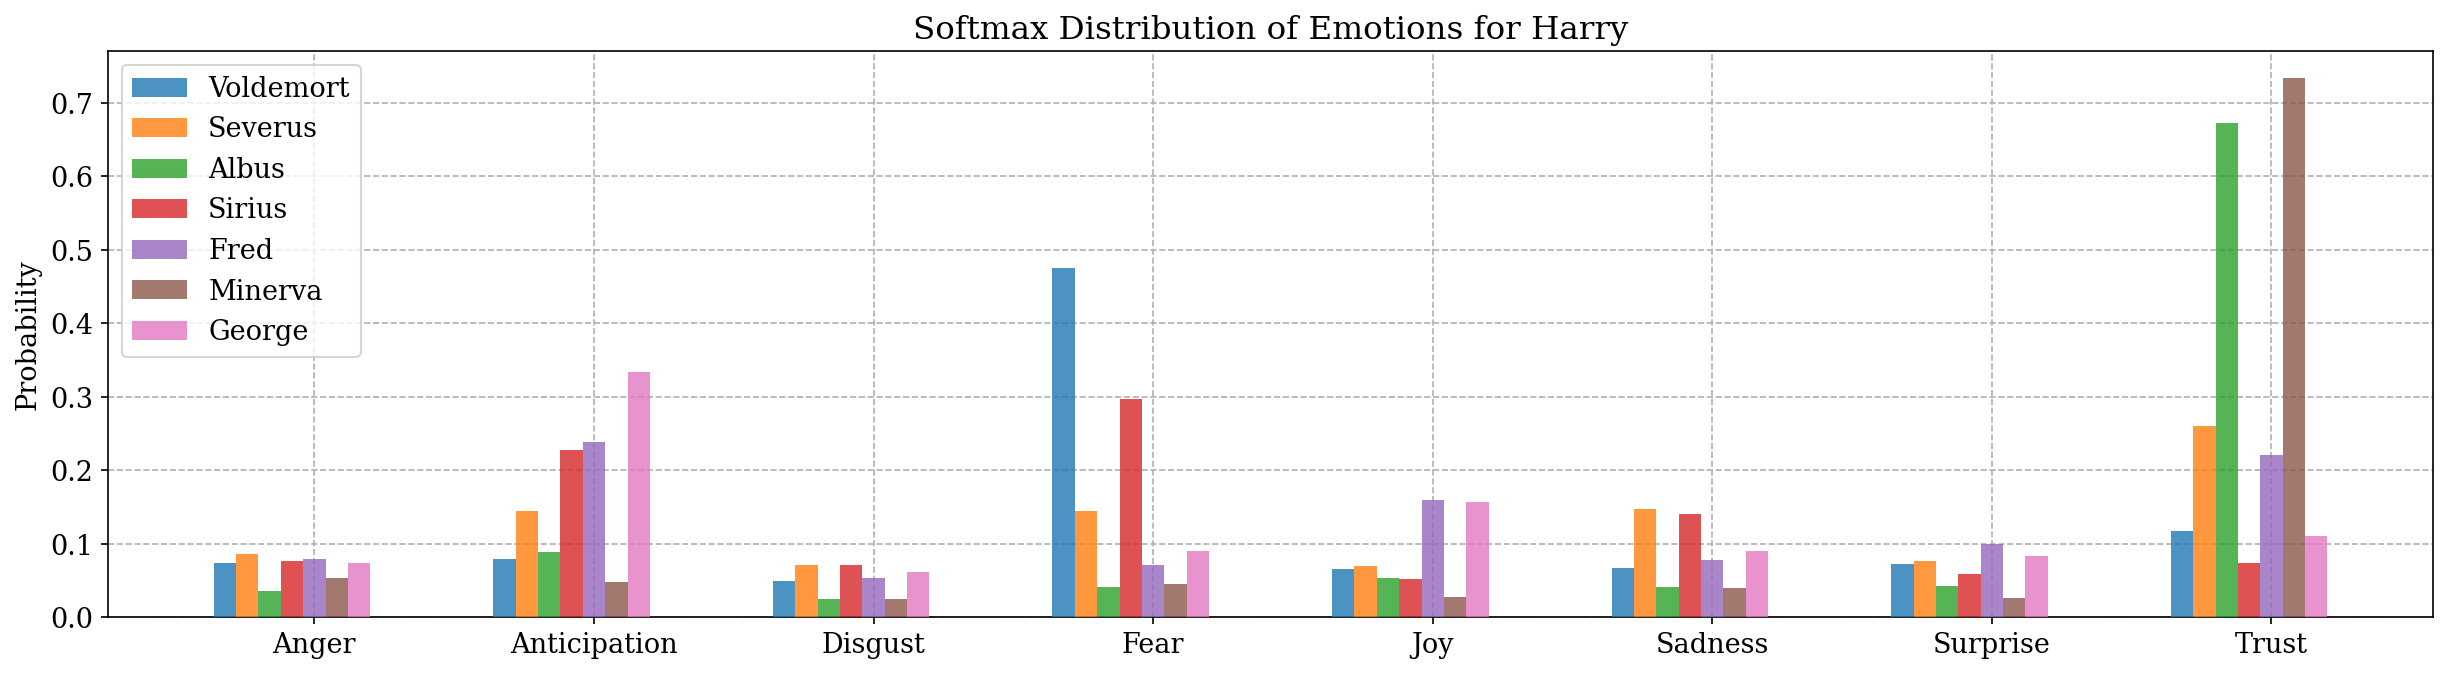

In [ ]:
source = 'Harry'
characters = ['Voldemort', 'Severus', 'Albus', 'Sirius', 'Fred', 'Minerva', 'George']

emotion_bars(df, source, characters)


## Wordclouds between Houses
#### Which words do the houses use when they talk to other houses??

16
 25%|██▌       | 4/16 [00:27<01:21,  6.77s/it]


KeyboardInterrupt: 

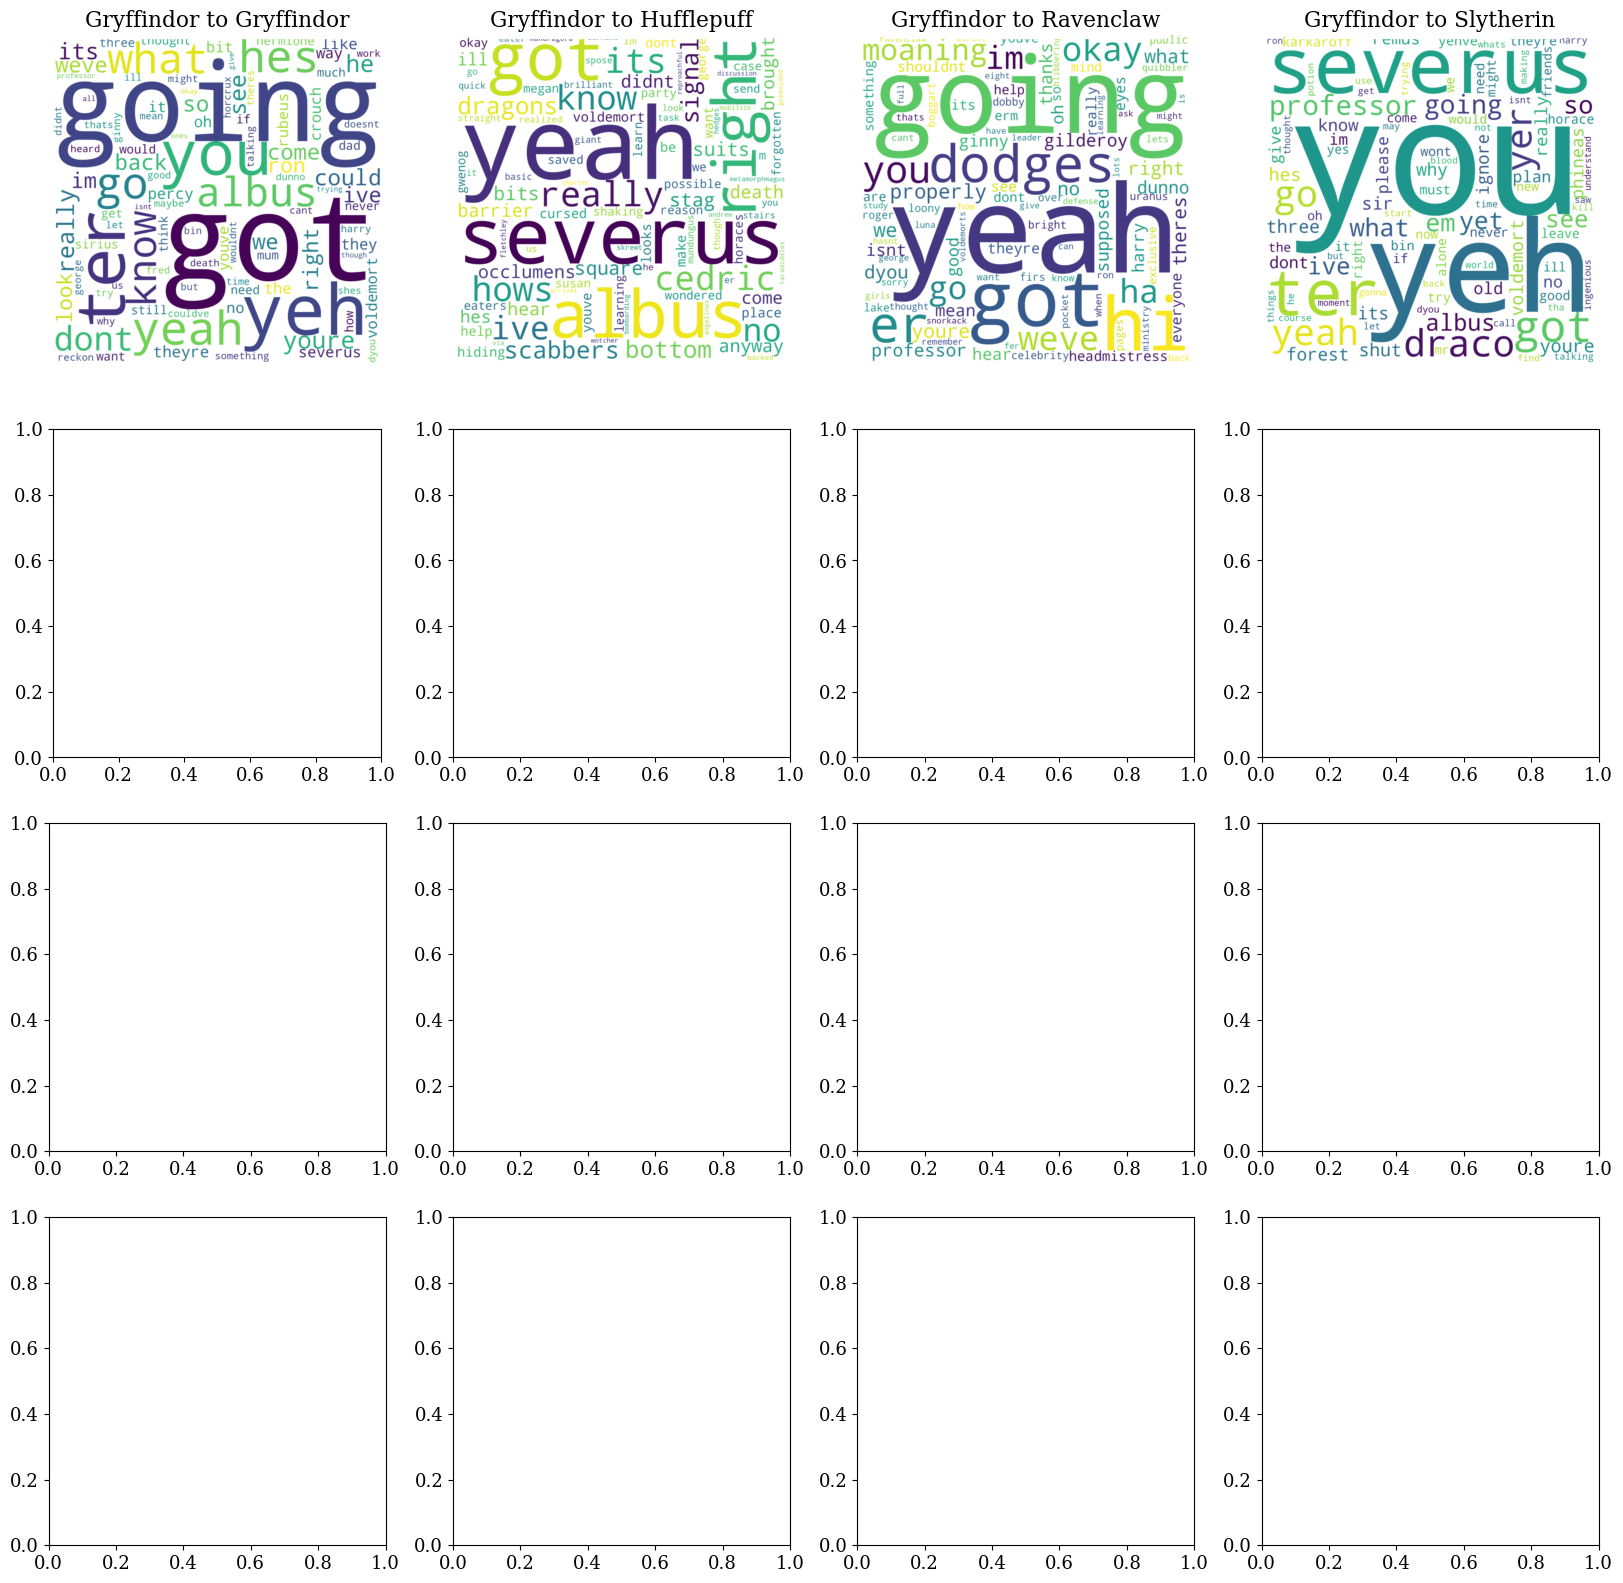

In [ ]:
WordCloudsHouses(df)


## Timeseries
### What is the sentiment (happiness) throughout the books ?? 
We simply find the mean happiness of all interaction in each chapter and show it as a timeline. <br>
Seems like something bad is happening in the end of book 3,4,5 and 6 ... Wonder if someone dies ??

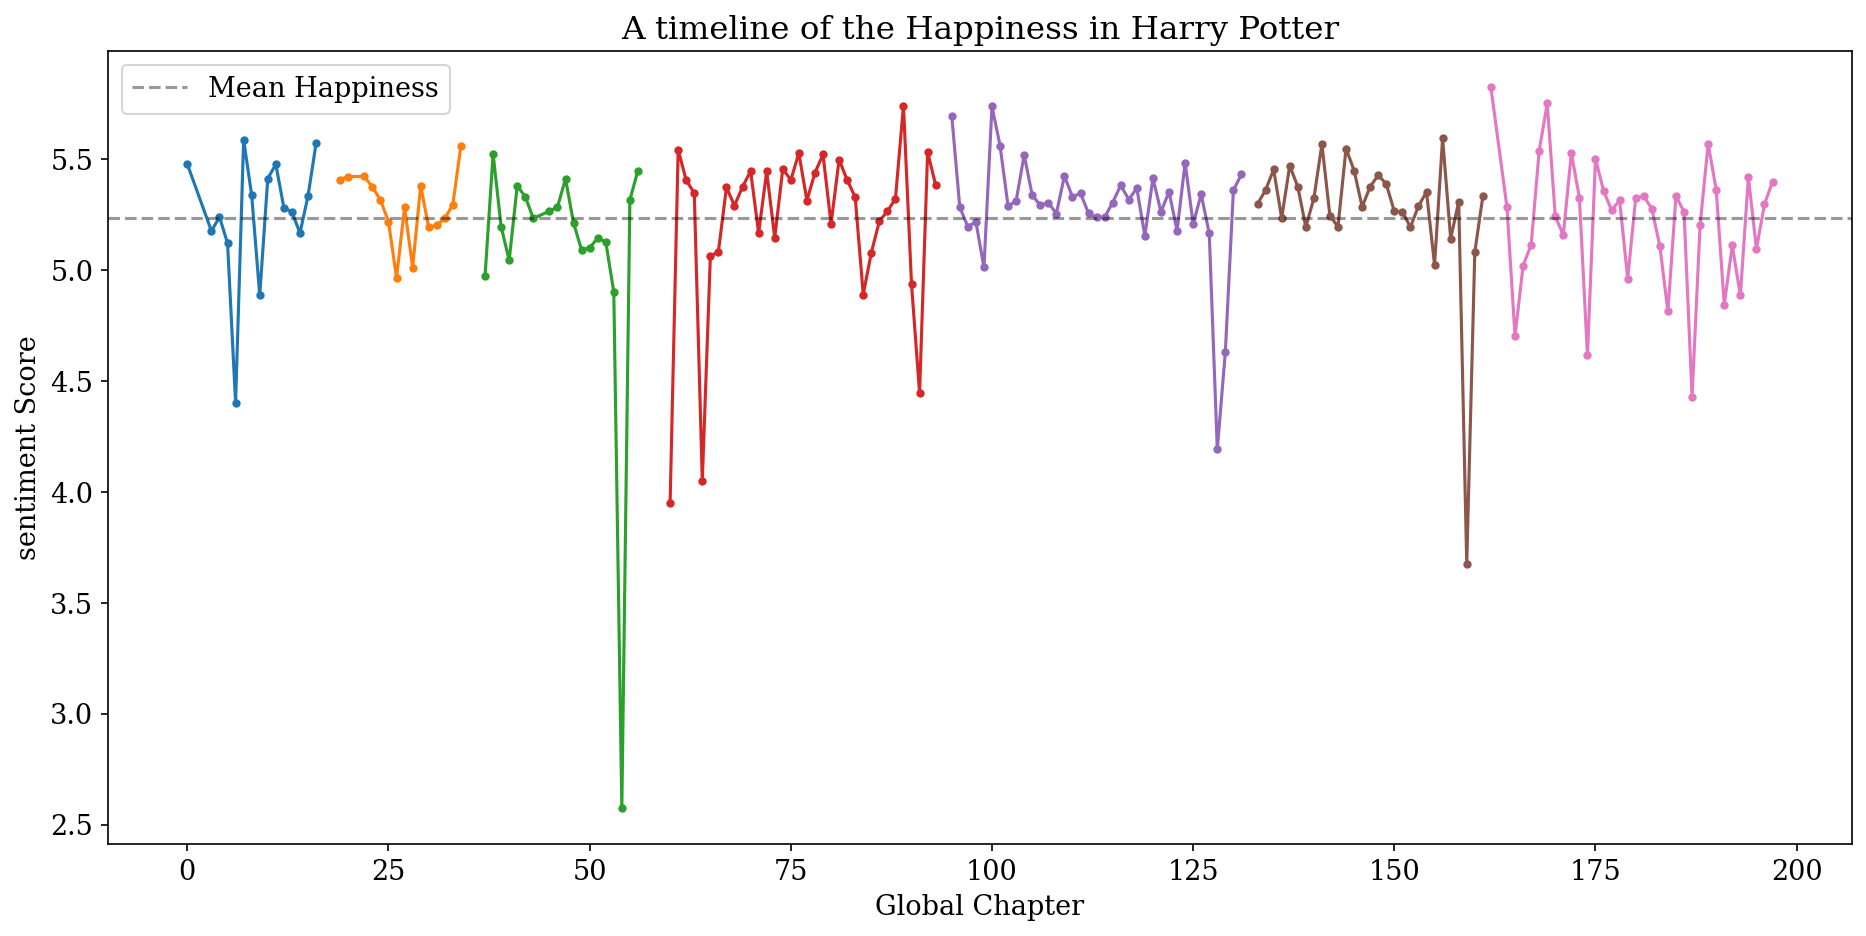

In [ ]:
TimeSeries(df, sentiment = 'Happiness')


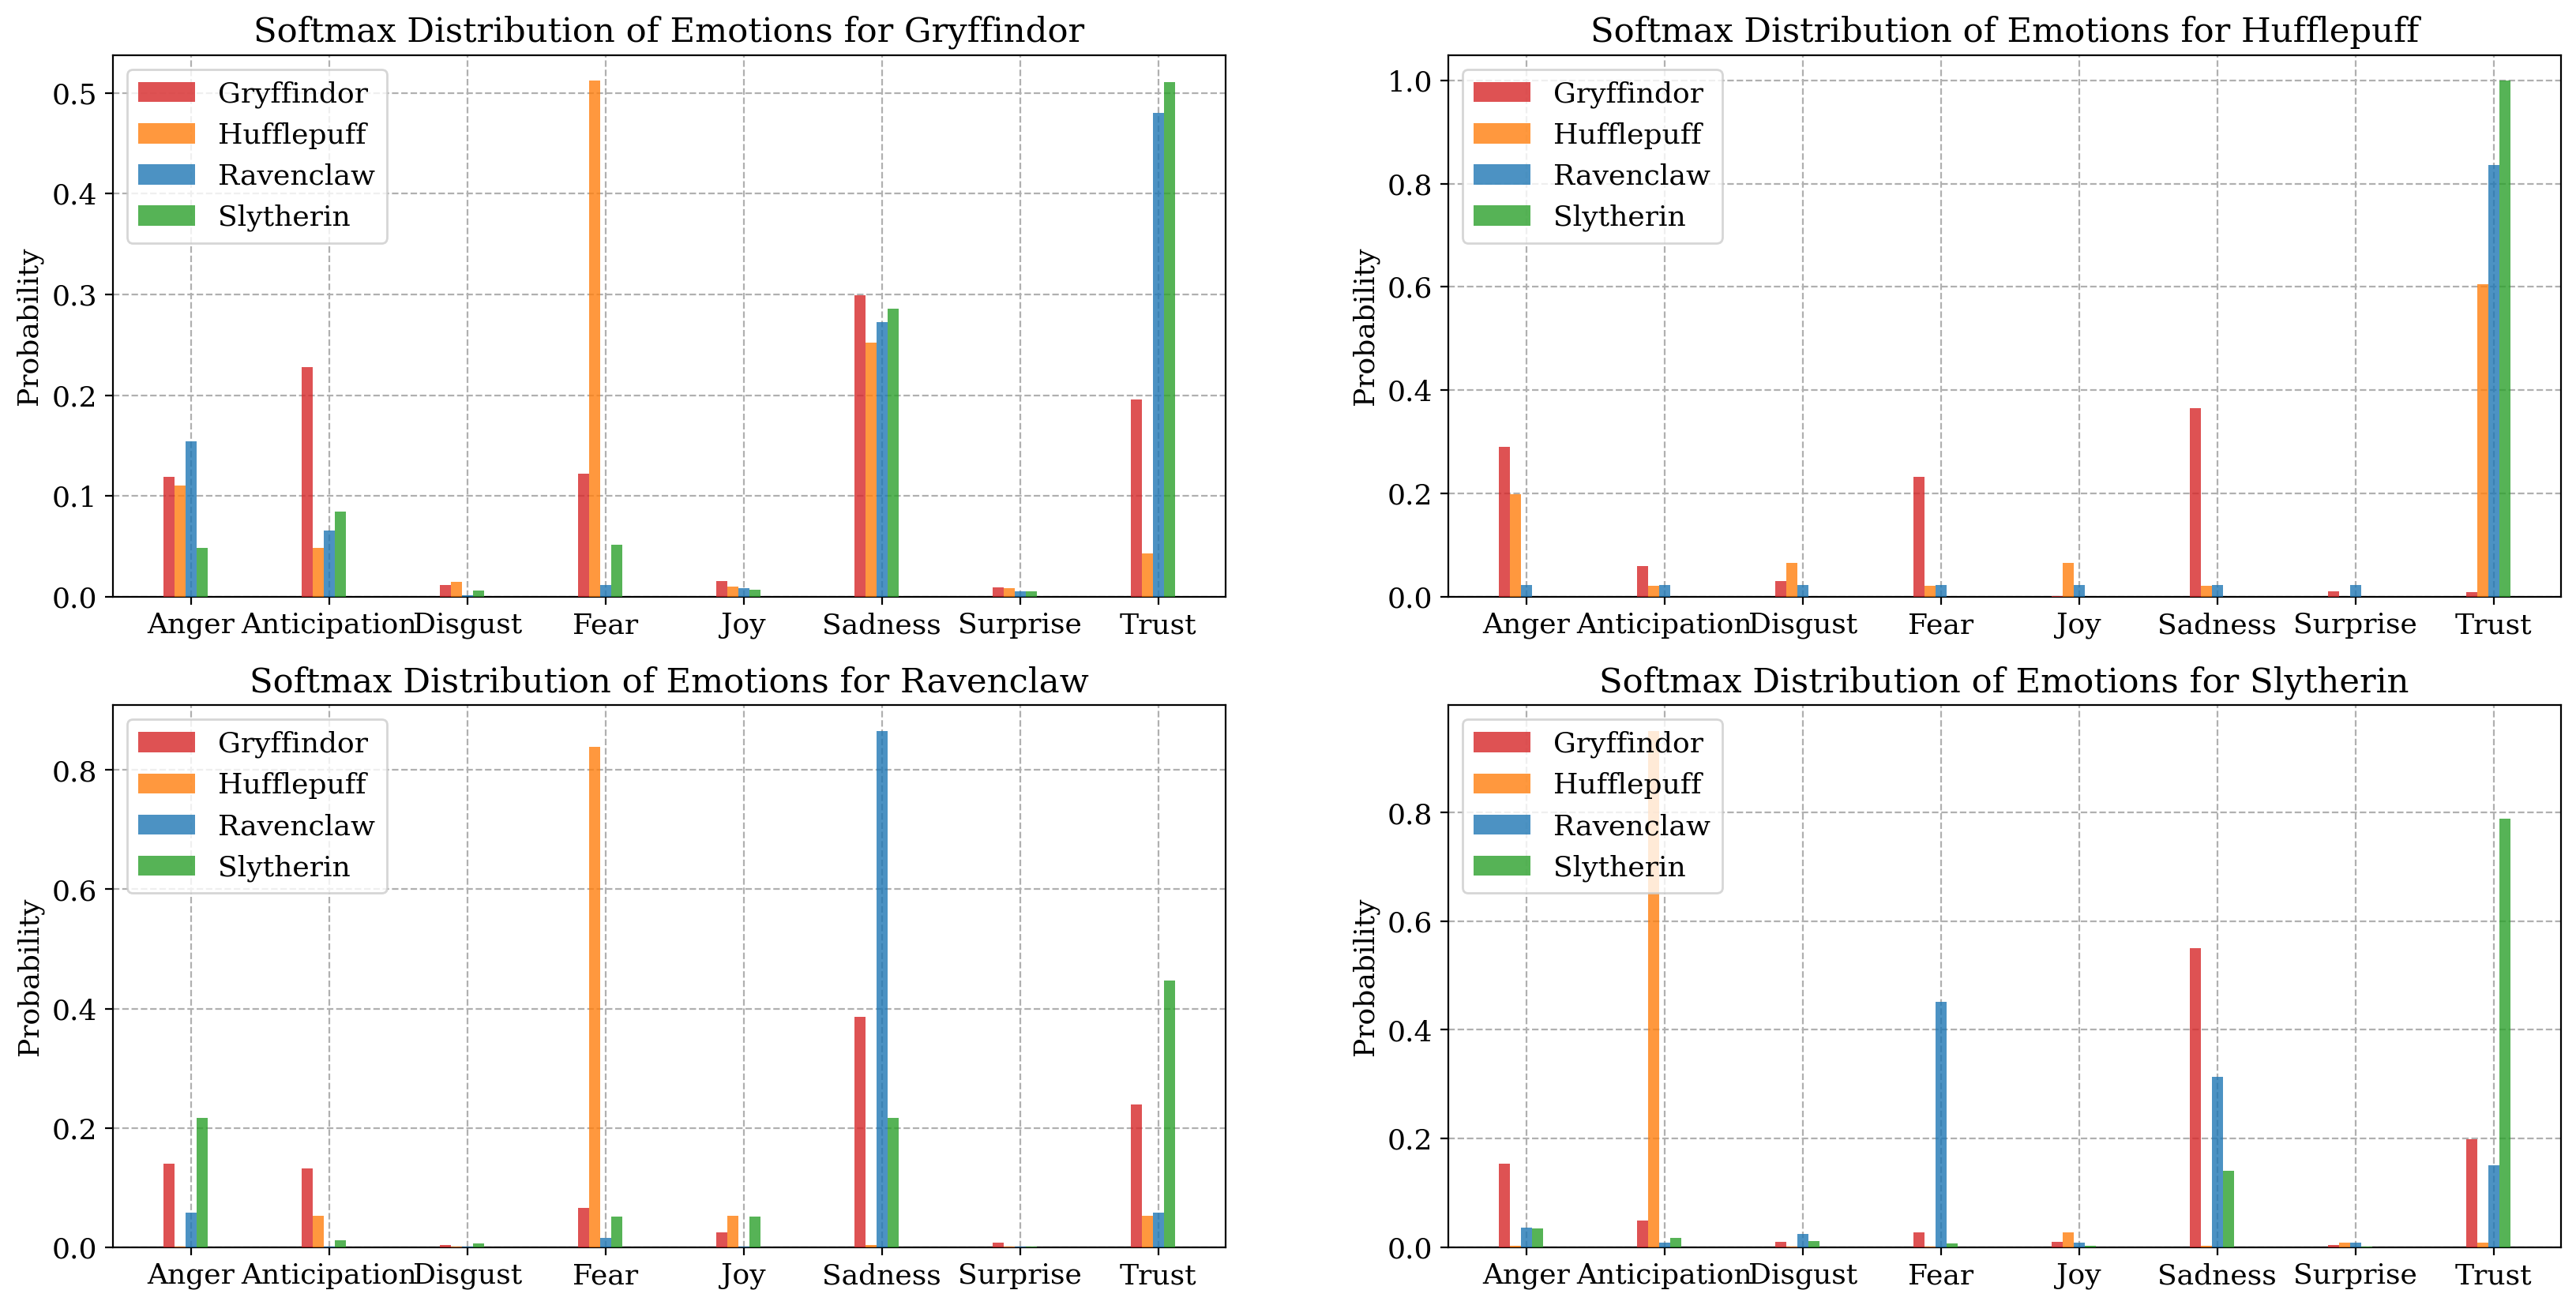

In [ ]:
H = df.groupby(['Source_house', 'Target_house']).agg({'Tokens':'sum'}).reset_index()
emotion_bar_houses(H, 'Source_house', 'Target_house','Tokens', beta = 50)



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=85fb65b4-b596-4730-837e-04e86eafe419' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>